In [73]:
# import warnings
# from pathlib import Path

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# data_dir = Path('../data')
# figure_dir = Path('../figures')
# figure_dir.mkdir(exist_ok=True)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
# district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
# institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

# districts_in_city = [
#     'Valli',
#     'Salakkalahti',
#     'Repola',
#     'Anina',
#     'Papula',
#     'P_Annan_kruunu',
#     'Hiekka',
#     'Pantsarlahti',
#     'Viipurin_esikaupunki',
#     'Paulovski',
#     'Havi',
#     'Saunalahti',
#     'Pietarin_esikaupunki',
# ]

# poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
# poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
# poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
# poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
# remove = poll_tax.in_russia_orthodox.copy()
# remove.loc['1906':] = 0
# poll_tax['orthodox'] = poll_tax.orthodox - remove
# health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
# health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
# foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
# language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
# religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
# difference = health_council - poll_tax.orthodox
# data = pd.DataFrame([
#     difference,
#     poll_tax.orthodox,
#     poll_tax.in_russia_orthodox,
#     poll_tax.total,
#     health_council,
#     foreigners,
#     language,
#     religion,
# ]).T
# data.columns = [
#     'difference',
#     'register_orthodox',
#     'orthodox_in_russia',
#     'register_total',
#     'health_council_orthodox',
#     'Russian_citizens',
#     'Russian_speakers',
#     'census_orthodox',
# ]
# data.interpolate(method='linear', inplace=True)
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
# plt.savefig(figure_dir / 'timeseries1.png')
# data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
# plt.savefig(figure_dir / 'timeseries2.png')

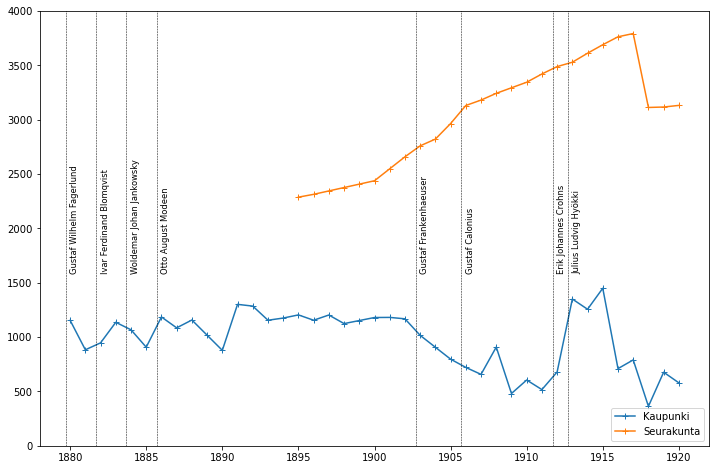

In [74]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

clerks = {
    'Gustaf Wilhelm Fagerlund': 1880,
    'Ivar Ferdinand Blomqvist': 1882,
    'Woldemar Johan Jankowsky': 1884,
    'Otto August Modeen': 1886,
    'Gustaf Frankenhaeuser': 1903,
    'Gustaf Calonius': 1906,
    'Erik Johannes Crohns': 1912,
    'Julius Ludvig Hyökki': 1913,
}

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
# remove = poll_tax.in_russia_orthodox.copy()
# remove.loc['1895':] = 0
# remove.loc['1912':] = 0
# poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
clerk = pd.Series({v: k for k, v in clerks.items()}, name='clerk')
data = pd.DataFrame([
    poll_tax.orthodox,
    health_council,
    clerk,
]).T
data = data.ffill()
starts = data.clerk.map(clerks)
data.columns = [
    'Kaupunki',
    'Seurakunta',
    'Henkikirjoittaja',
]
data.plot(
    marker='+',
    legend=True,
    ylim=(0, 4_000),
    figsize=(12, 8),
)
for c, y in clerks.items():
    plt.axvline(y-0.3, ymin=0, ymax=4000, color='black', ls='--', lw=0.5)
    plt.text(x=y, y=1600, s=c, rotation='vertical', fontsize='small')
plt.legend()
plt.savefig(figure_dir / 'timeseries.png')

In [75]:
import arviz as az
import pymc3 as pm
from patsy import dmatrix

regression_data = data.loc['1880':'1917', 'Kaupunki'].copy()
missing_years = [1881, 1882, 1884, 1885, 1887] + list(range(1889, 1893)) + list(range(1903, 1913)) + [1916, 1917]
regression_data.loc[regression_data.index.isin(missing_years)] = np.nan # imputation
# regression_data.drop(index=missing_years, inplace=True) # no imputation
regression_data = pd.DataFrame(data=({
    'Vuosi': regression_data.index,
    'Kaupunki': regression_data,
    'Seurakunta': data.loc['1880':'1917', 'Seurakunta'],
}))

C:\Users\antth\Anaconda3\envs\pymc3\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in orthodox contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [orthodox_missing, sigma, w, a]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 35 seconds.


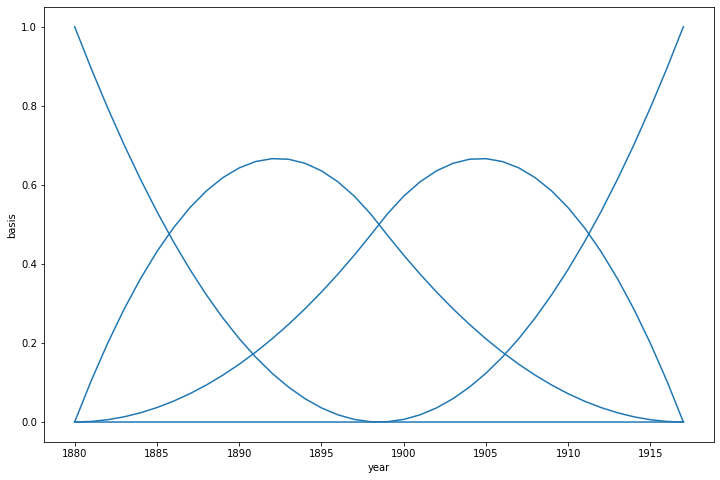

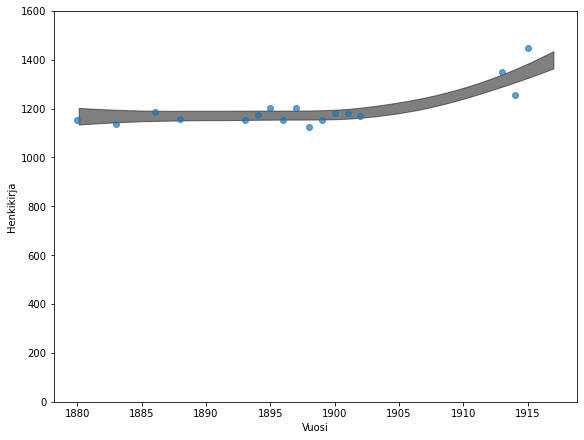

C:\Users\antth\Anaconda3\envs\pymc3\lib\site-packages\arviz\plots\plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (65) in plot_posterior, generating only 40 plots
  warnings.warn(


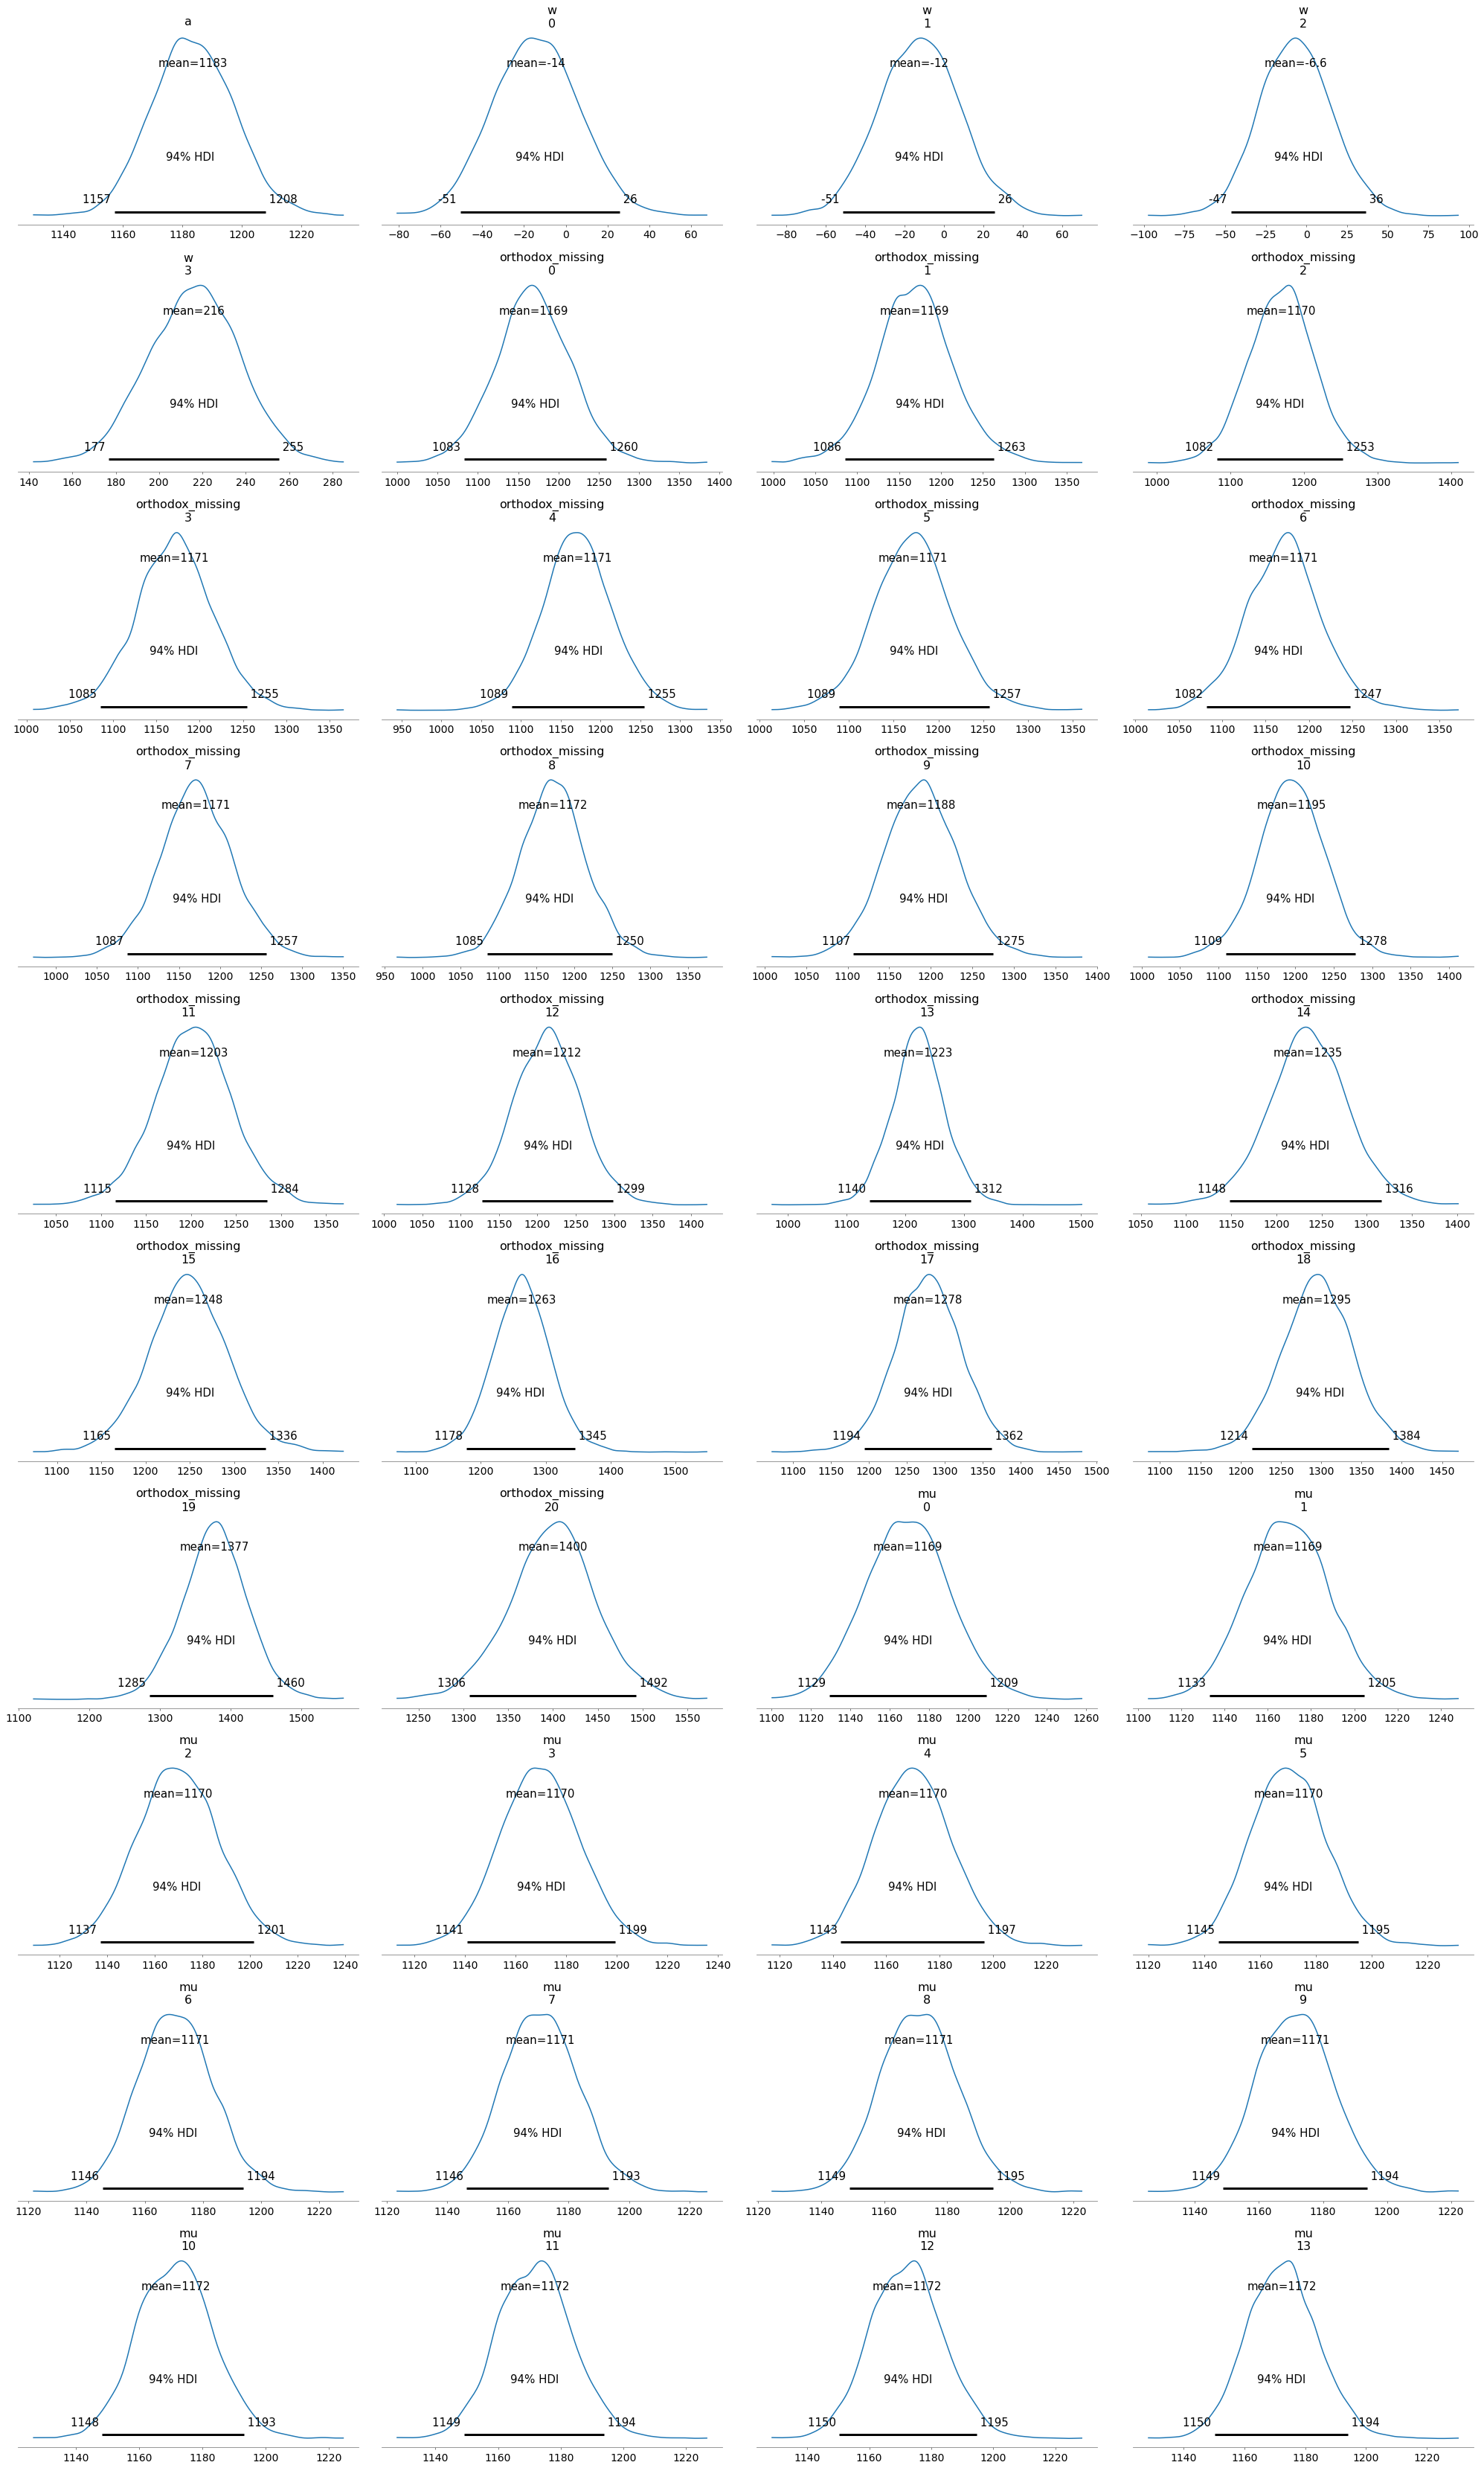

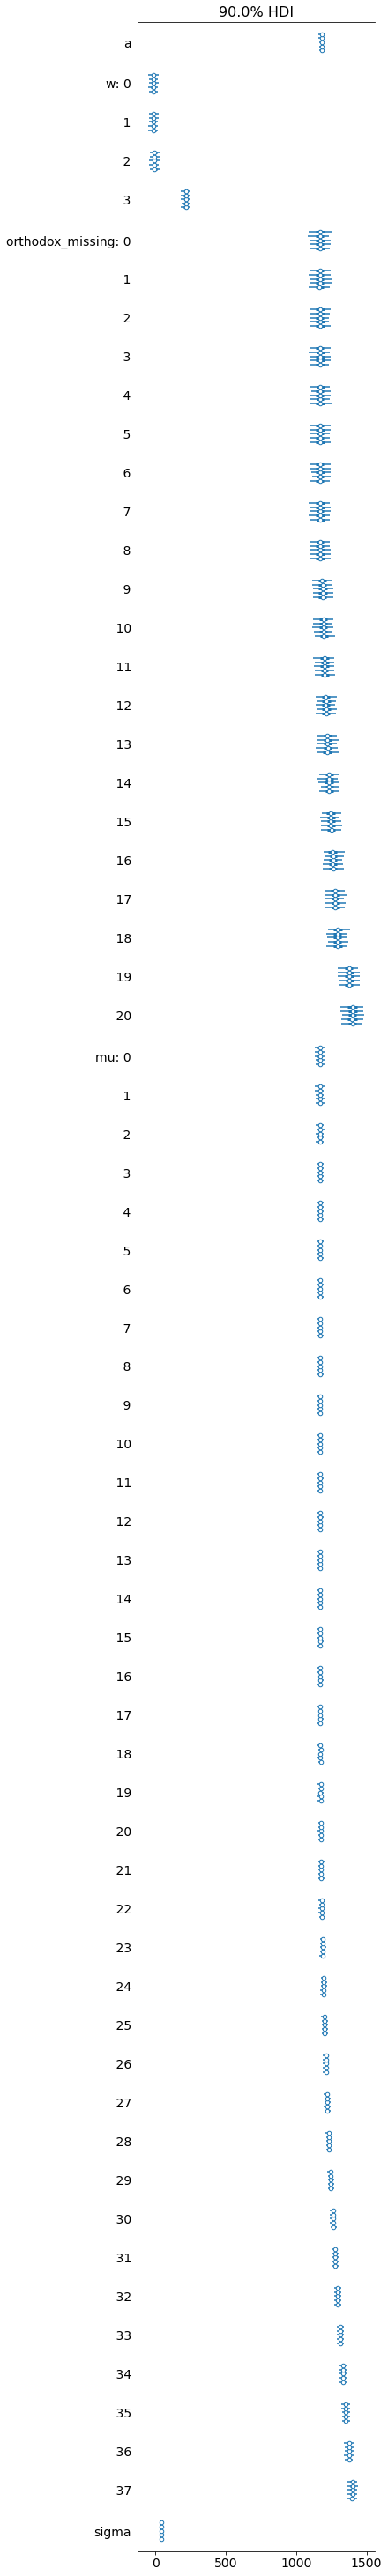

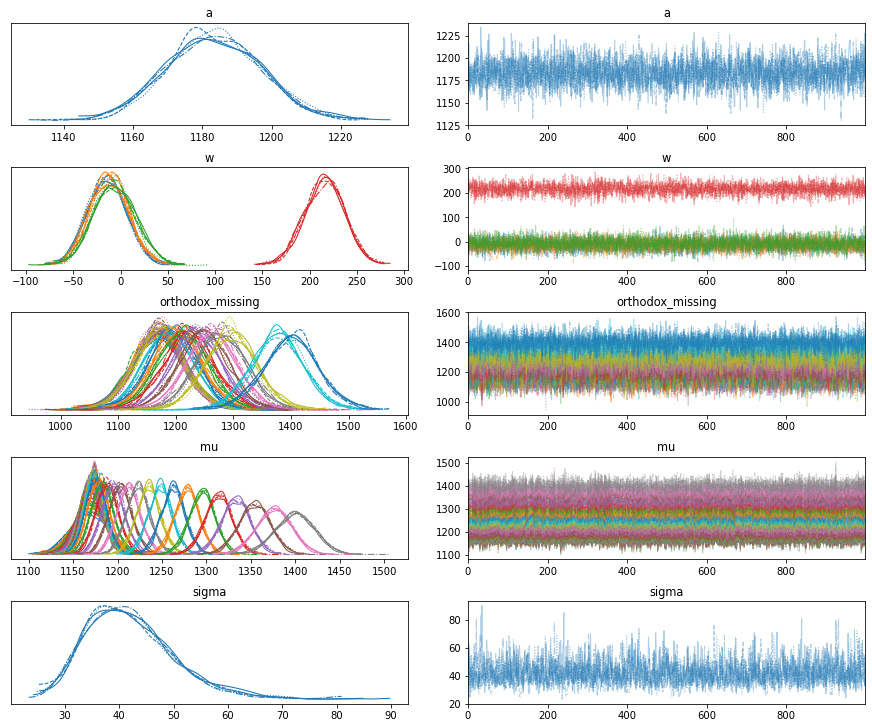

In [76]:
n_knots = 3
knot_list = np.linspace(regression_data.Vuosi.min(), regression_data.Vuosi.max(), n_knots)
B = dmatrix(
    "bs(year, knots=knots, degree=2, include_intercept=True) - 1",
    {"year": regression_data.Vuosi, "knots": knot_list[1:-1]},
)

_, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(n_knots + 1):
    ax.plot(regression_data.Vuosi, (B[:, i]), color="C0")
ax.set_xlabel("year")
ax.set_ylabel("basis")

mu_w = [0] * n_knots + [200]
with pm.Model() as model:
    a = pm.Normal("a", 1200, 25)
    w = pm.Normal("w", mu=mu_w, sd=25, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.HalfNormal("sigma", sd=50)
    orthodox = pm.Normal("orthodox", mu, sigma, observed=regression_data.Kaupunki)
    posterior = pm.sample(1000, tune=1000, chains=5)

# with pm.Model() as model:
#     a = pm.Normal("a", 1200, 25)
#     w = pm.Normal("w", mu=0, sd=50, shape=B.shape[1])
#     mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
#     sigma = pm.HalfNormal("sigma", sd=50)
#     orthodox = pm.Normal("orthodox", mu, sigma, observed=regression_data.Kaupunki)
#     posterior = pm.sample(1000, tune=5000)

# weight_m = np.vstack((regression_data.Vuosi, regression_data.Vuosi ** 2, regression_data.Vuosi ** 3))
# with pm.Model() as model:
#     a = pm.Normal("a", 0, 1)
#     b = pm.Normal("b", 0, 1, shape=3)
#     sigma = pm.HalfNormal("sigma", sd=1)
#     mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
#     orthodox = pm.Normal("orthodox", mu=mu, sd=sigma, observed=regression_data.Kaupunki)
#     posterior = pm.sample(1000, tune=5000)

pm.model_graph.ModelGraph(model)
plt.show()

ax = az.plot_hdi(regression_data.Vuosi, posterior["mu"], color="k", hdi_prob=0.9)
ax.plot(regression_data.Vuosi, regression_data.Kaupunki, "o", alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(8, 6)
ax.set_ylim(0, 1600)
ax.set_xlabel("Vuosi")
ax.set_ylabel("Henkikirja")
plt.show()

az.plot_posterior(posterior)
plt.show()

az.plot_forest(posterior, hdi_prob=0.9, combined=False)
plt.show()

az.plot_trace(posterior)
plt.show()

In [77]:
om_hdi = pm.stats.hdi(posterior, hdi_prob=0.9)['orthodox_missing'].values

missing_orthodox = pd.DataFrame(
    data=om_hdi,
    columns='min_ max_'.split(),
    index=missing_years,
)
bad_data = data.loc[data.index.isin(missing_years), 'Kaupunki']
missing_orthodox = missing_orthodox.values - bad_data.values[:, np.newaxis]
missing_orthodox = pd.DataFrame(
    data=missing_orthodox,
    columns='vähintään enintään'.split(),
    index=missing_years,
).round(-1).applymap(int)
(data_dir / 'processed').mkdir(exist_ok=True)
missing_orthodox.to_csv(data_dir / 'processed' / 'imputated.csv')
missing_orthodox

,vähintään,enintään
1881,210,360
1882,150,300
1884,30,170
1885,190,330
1887,10,160
1889,80,230
1890,220,370
1891,-200,-50
1892,-180,-40
1903,100,250
